Restarted GenAMM (Python 3.11.4)

In [1]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_swap = df_swap[[
    'block_number', 'amount0', 'transaction_price',
    'Event', 'amount1', 'tick', 'log_index', 'liquidity']]
df_swap_x2y = df_swap[ df_swap.Event=='Swap_X2Y' ]
df_swap_y2x = df_swap[ df_swap.Event=='Swap_Y2X' ]

Extracting delta ticks:   0%|          | 0/969761 [00:00<?, ?it/s]

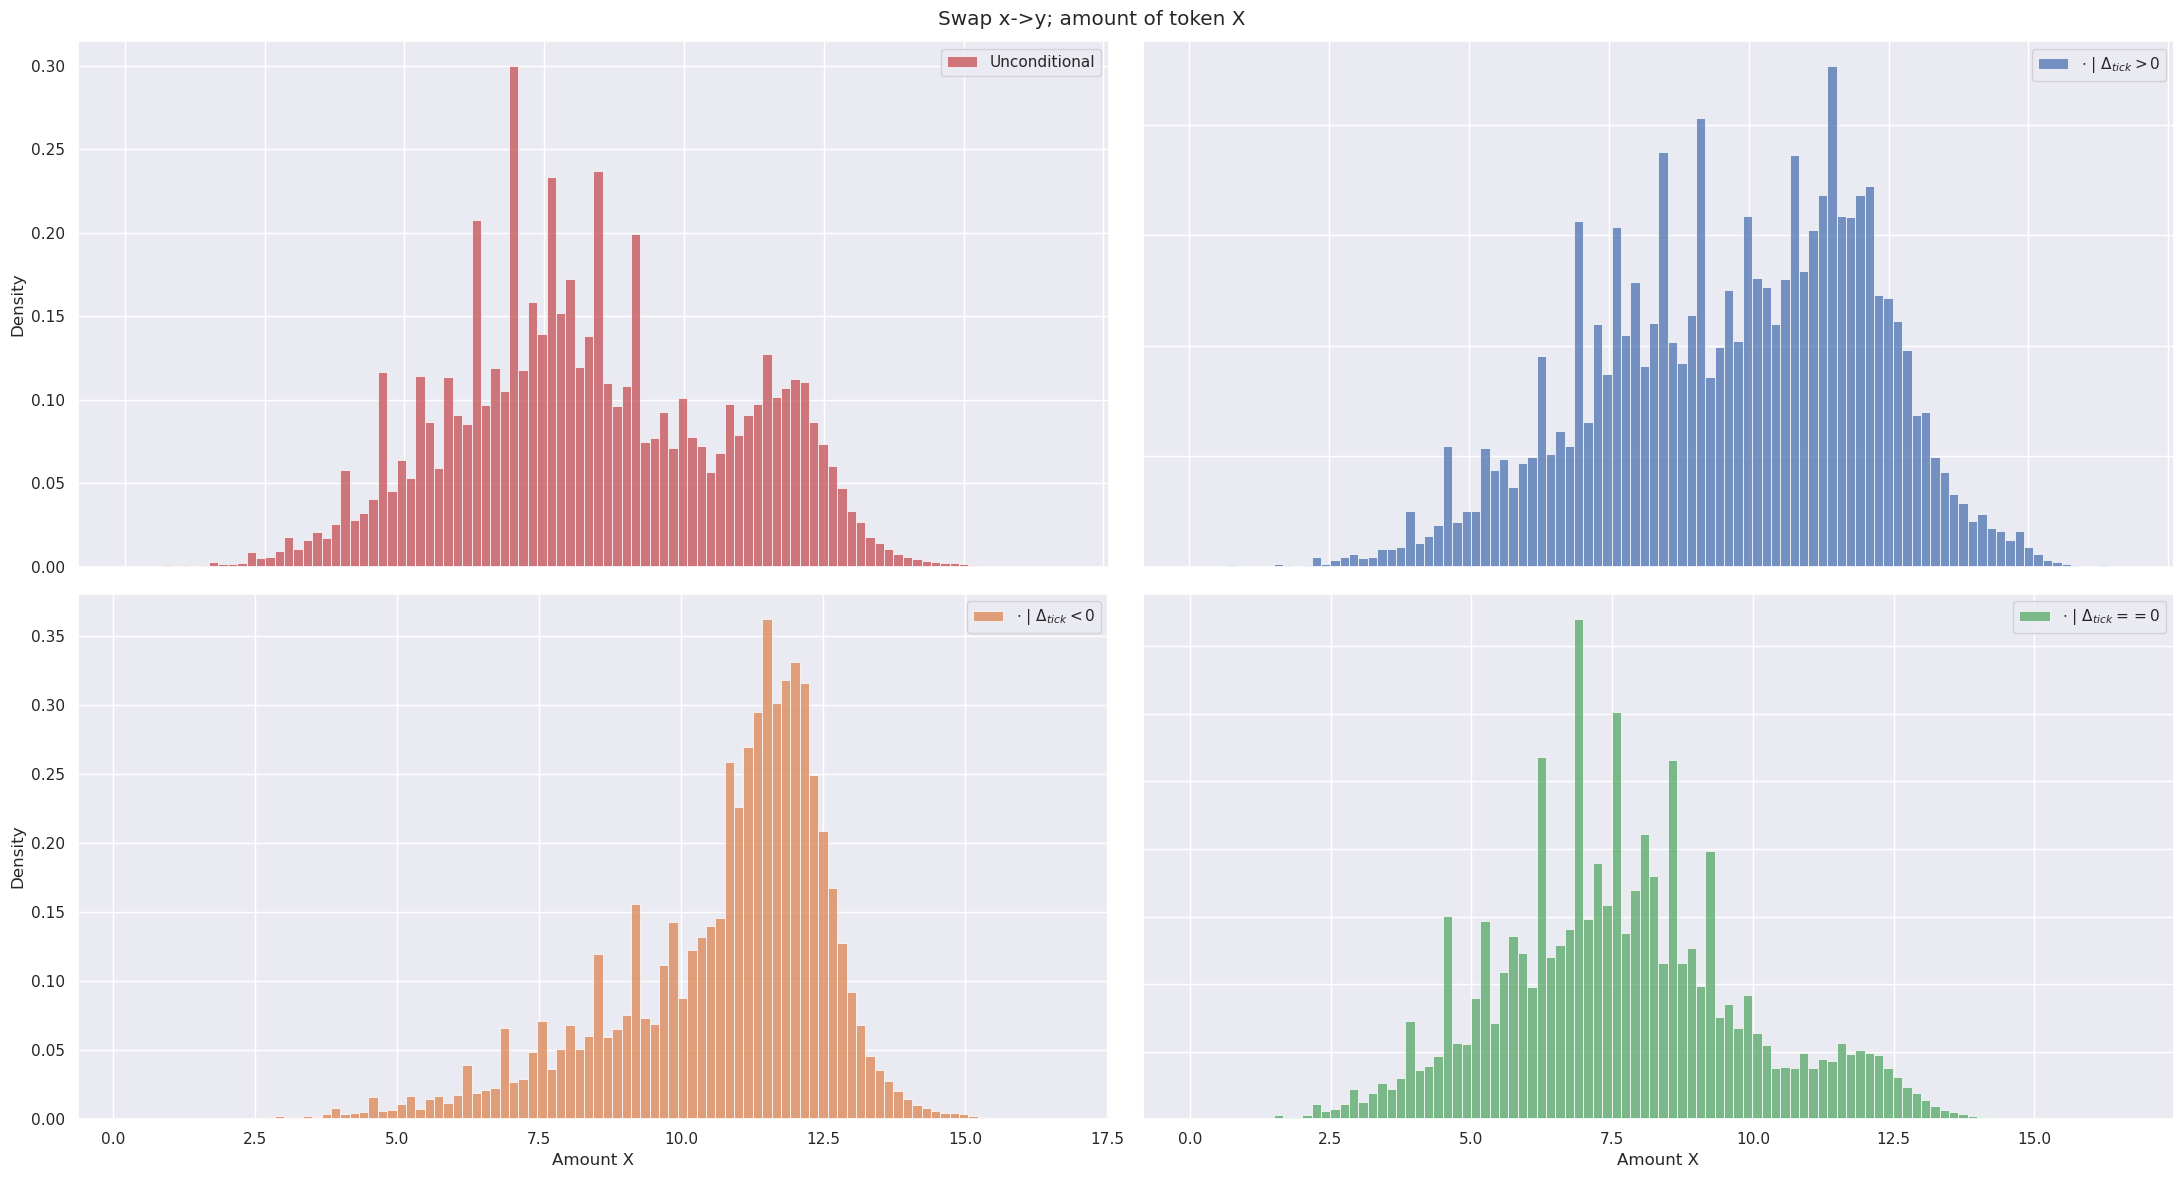

In [2]:
x_test = np.log(df_swap_x2y.amount0)[2:]
x_test = x_test[x_test>0]

df_temp = df_swap.tick.diff().dropna()
cond = list()
for ev in tqdm(x_test.index, desc='Extracting delta ticks'):
    # if ev.day
    # curr_val = df_temp.loc[:ev]
    # curr_val, curr_idx = curr_val.iloc[-1], curr_val.index[-1]
    # df_temp = df_temp[ df_temp.index>=curr_idx ]
    cond.append( df_temp.loc[:ev].iloc[-1] )
cond = np.array(cond)

fig, ax = plt.subplots(2, 2, figsize=(22, 12))
p_row, p_col = 0, 0
# sns.histplot(x_test[cond>0], stat='density', bins=100, alpha=0.3, color=sns.color_palette()[0], ax=ax[p_row, p_col], label=r'$\Delta_{tick}>0$')
# sns.histplot(x_test[cond<0], stat='density', bins=100, alpha=0.3, color=sns.color_palette()[1], ax=ax[p_row, p_col], label=r'$\Delta_{tick}<0$')
# sns.histplot(x_test[cond==0], stat='density', bins=100, alpha=0.3, color=sns.color_palette()[2], ax=ax[p_row, p_col], label=r'$\Delta_{tick}==0$')
sns.histplot(x_test, stat='density', bins=100, color=sns.color_palette()[3], ax=ax[p_row, p_col], label='Unconditional')
ax[p_row, p_col].legend()
if p_row == 0:
    ax[p_row, p_col].set_xlabel('')
    ax[p_row, p_col].set_xticklabels([])
else:
    ax[p_row, p_col].set_xlabel('Amount X')
if p_col == 1:
    ax[p_row, p_col].set_ylabel('')
    ax[p_row, p_col].set_yticklabels([])
#--------------------------------
p_row, p_col = 0, 1
sns.histplot(x_test[cond>0], stat='density', bins=100, color=sns.color_palette()[0], ax=ax[p_row, p_col], label=r'$\cdot \ | \ \Delta_{tick}>0$')
ax[p_row, p_col].legend()
if p_row == 0:
    ax[p_row, p_col].set_xlabel('')
    ax[p_row, p_col].set_xticklabels([])
else:
    ax[p_row, p_col].set_xlabel('Amount X')
if p_col == 1:
    ax[p_row, p_col].set_ylabel('')
    ax[p_row, p_col].set_yticklabels([])
#--------------------------------
p_row, p_col = 1, 0
sns.histplot(x_test[cond<0], stat='density', bins=100, color=sns.color_palette()[1], ax=ax[p_row, p_col], label=r'$\cdot \ | \ \Delta_{tick}<0$')
ax[p_row, p_col].legend()
if p_row == 0:
    ax[p_row, p_col].set_xlabel('')
    ax[p_row, p_col].set_xticklabels([])
else:
    ax[p_row, p_col].set_xlabel('Amount X')
if p_col == 1:
    ax[p_row, p_col].set_ylabel('')
    ax[p_row, p_col].set_yticklabels([])
#--------------------------------
p_row, p_col = 1, 1
sns.histplot(x_test[cond==0], stat='density', bins=100, color=sns.color_palette()[2], ax=ax[p_row, p_col], label=r'$\cdot \ | \ \Delta_{tick}==0$')
ax[p_row, p_col].legend()
if p_row == 0:
    ax[p_row, p_col].set_xlabel('')
    ax[p_row, p_col].set_xticklabels([])
else:
    ax[p_row, p_col].set_xlabel('Amount X')
if p_col == 1:
    ax[p_row, p_col].set_ylabel('')
    ax[p_row, p_col].set_yticklabels([])

plt.suptitle('Swap x->y; amount of token X')
plt.tight_layout()
plt.show()

In [4]:
from scipy.special import gamma as gamma_func

class qGMM():
    def __init__(self, n_components, q, max_iter=100, tol=1e-4):
        self.n_components = n_components
        # Check q
        if q>=3:
            raise ValueError('q must be < 3')
        self.q = q
        self.A = (5-3*self.q) / (3-self.q)
        self.max_iter = max_iter
        self.tol = tol

        # Compute the normalization constant for the q-Gaussian
        if self.q < 1:
            self.Aq = 2*np.sqrt(2*np.pi) * gamma_func(1/(1-self.q)) /\
                ( (3-self.q)*np.sqrt(1-self.q)*gamma_func((3-self.q)/(2*(1-self.q))) )
        elif self.q > 1:
            self.Aq = np.sqrt(2*np.pi) * gamma_func((3-self.q)/(2*(self.q-1))) /\
                ( np.sqrt(self.q-1) * gamma_func(1/(self.q-1)) )

    def _q_exp(self, z):
        if self.q != 1:
            temp = 1 + (1-self.q)*z
            return np.where(temp>0, temp**(1/(1-self.q)), 0)
        else:
            return np.exp(z)

    def _q_gaussian_pdf(self, x, mu, sigma2):
        # Compute the pdf
        if self.q != 1:
            pdf = self._q_exp( -(x-mu)**2 / (2*sigma2) ) / (np.sqrt(sigma2) * self.Aq)
        else:
            pdf = np.exp(-(x-mu)**2 / (2*sigma2)) / (np.sqrt(2*np.pi) * np.sqrt(sigma2))
        return pdf

    def fit(self, X, init_means=None, init_vars=None):
        # Check x
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        N = len(X)

        # Initialize parameters
        self.weights_ = np.ones(self.n_components) / self.n_components
        if isinstance(init_means, type(None)):
            self.means_ = X[np.random.choice(N, self.n_components, replace=False)]
        else:
            self.means_ = init_means
        if isinstance(init_vars, type(None)):
            self.vars_ = np.ones(self.n_components)*np.var(X)
        else:
            self.vars_ = init_vars
        '''quantiles = np.quantile(
            X, np.linspace(0,1,self.n_components+2))
        self.means_ = quantiles[1:-1]
        self.vars_ = np.array([
            np.mean([
                (quantiles[qu+1]-quantiles[qu])**2,
                (quantiles[qu]-quantiles[qu-1])**2
                ])for qu in range(1, self.n_components+1)
        ])
        print(self.means_, self.vars_)'''

        prev_log_likelihood = -np.inf
        flag = False
        for _ in range(self.max_iter):
            log_p_mat = self._estimate_weighted_log_prob(X)
            min_log_p_mat = np.min(log_p_mat)
            # E-step
            if min_log_p_mat == -np.inf:
                #print('Sono nel cerchio sbagliato')
                old_means, old_vars = self.means_.copy(), self.vars_.copy()
                p_mat = self._estimate_weighted_prob(X)
                c_mat = self._e_step_nolog(
                    X, p_mat)
                X_temp = X[ ~np.isnan(c_mat[:,0])]
                c_mat = c_mat[ ~np.isnan(c_mat[:,0]), :]
                # M-step
                self._m_step(X_temp, c_mat)
                # print(self.means_, self.vars_)
                # print(np.any(np.isnan(c_mat)))
            else:
                #print('Giusto')
                c_mat = self._e_step(X, log_p_mat)
                # M-step
                self._m_step(X, c_mat)

            # Check for convergence
            if min_log_p_mat == -np.inf:
                new_log_likelihood = self._log_likelihood_no_log(p_mat)
                if np.max(np.abs(old_means - self.means_)) < self.tol:
                    flag = True
                    break
                if np.max(np.abs(old_vars - self.vars_)) < self.tol:
                    flag = True
                    break
            else:
                new_log_likelihood = self._log_likelihood(log_p_mat)
                if np.abs(new_log_likelihood - prev_log_likelihood) < self.tol:
                    flag = True
                    break

            prev_log_likelihood = new_log_likelihood

        if flag:
            self.log_likelihood = new_log_likelihood
            self.bic = 2*self.n_components*np.log(N) - 2*self.log_likelihood
        else:
            print("qGMM fit did not converge.")
            self.log_likelihood = np.nan
            self.bic = np.nan
        #return self

    def _e_step_nolog(self, X, weighted_log_prob):
        log_prob_norm = np.sum(weighted_log_prob, axis=1)
        return weighted_log_prob / log_prob_norm[:, np.newaxis]

    def _e_step(self, X, weighted_log_prob):
        log_prob_norm = self._logsumexp(weighted_log_prob, axis=1)
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        return np.exp(log_resp)

    def _m_step(self, X, c_mat):
        C_vec = np.sum(c_mat, axis=0)
        self.weights_ = C_vec / C_vec.sum()
        self.means_ = np.dot(c_mat.T, X) / C_vec

        eps2 = (X[:, np.newaxis] - self.means_)**2
        self.vars_ = list()
        for k in range(self.n_components):
            self.vars_.append(
                np.vdot(c_mat[:,k], (X-self.means_[k])**2) * self.A / C_vec[k])
        self.vars_ = np.array(self.vars_)

    def _estimate_weighted_log_prob(self, X):
        log_probs = self._estimate_log_prob(X)
        augmented_log_price = np.array(
            list(np.log(self.weights_))*len(X)).reshape(-1,self.n_components)
        return (augmented_log_price + log_probs)

    def _estimate_log_prob(self, X):
        return np.array([np.log(self._q_gaussian_pdf(X, mu, var))
                         for mu, var in zip(self.means_, self.vars_)]).T

    def _estimate_weighted_prob(self, X):
        probs = np.array([
            self._q_gaussian_pdf(X, mu, var) for mu, var in zip(
                self.means_, self.vars_)]).T
        augmented_price = np.array(
            list(self.weights_)*len(X)).reshape(-1,self.n_components)
        return (augmented_price * probs)

    def _log_likelihood(self, log_p_mat):
        return self._logsumexp(log_p_mat, axis=1).sum()

    def _log_likelihood_no_log(self, p_mat):
        return np.log(np.sum(p_mat, axis=1)).sum()

    def _logsumexp(self, a, axis=None, keepdims=False):
        a_max = np.amax(a, axis=axis, keepdims=True)
        tmp = np.exp(a - a_max)
        '''if np.any(np.isnan(tmp)) and (not np.any(np.isnan(a_max))):
            print(f"NaNs in pdf: {self.means_}, {self.vars_}")
            print(np.max(a_max), np.min(a_max))
            print(np.max(a), np.min(a))
            print(np.any(np.isnan(a - a_max)))'''
        s = np.sum(tmp, axis=axis, keepdims=keepdims)
        out = np.log(s)
        if not keepdims:
            a_max = np.squeeze(a_max, axis=axis)
        out += a_max
        return out
    
    def pdf(self, z):
        return np.sum([self.weights_[k] * self._q_gaussian_pdf(
            z, self.means_[k], self.vars_[k]
            ) for k in range(self.n_components)], axis=0)

In [8]:
def optimize_qGMM(X, max_iter=1_000, tol=1e-6, seed=None):
    from scipy.optimize import Bounds
    from scipy.optimize import minimize

    def objective(q, X, max_iter, tol, seed):
        best_ll, best_bic, best_nc = -np.inf, np.inf, None
        for nc in [2, 3]:
            np.random.seed(seed)
            q_gmm = qGMM(n_components=nc, q=q, max_iter=max_iter, tol=tol)
            q_gmm.fit(X)
            if q_gmm.bic < best_bic:
                best_bic = q_gmm.bic
                best_ll = q_gmm.log_likelihood
                best_nc = nc
        return -best_ll, best_nc
    
    initial_guess = 1.25
    bounds = Bounds(1e-6, 5/3-1e-6)
    result1 = minimize(lambda q: objective(q, X, max_iter, tol, seed)[0],
                      initial_guess, method='SLSQP', bounds=bounds)
    
    initial_guess = 0.9
    result2 = minimize(lambda q: objective(q, X, max_iter, tol, seed)[0],
                      initial_guess, method='SLSQP', bounds=bounds)

    result = result1 if result1.fun < result2.fun else result2
    return result.x, objective(result.x, X, max_iter, tol, seed)[1], result

In [11]:
opt_res = optimize_qGMM(x_test, seed=2)

qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.


In [12]:
print(opt_res)

(array([1.04999958]), 2,  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2223006.7532253945
       x: [ 1.050e+00]
     nit: 8
     jac: [ 5.250e+00]
    nfev: 22
    njev: 8)


-2223006.7532255906


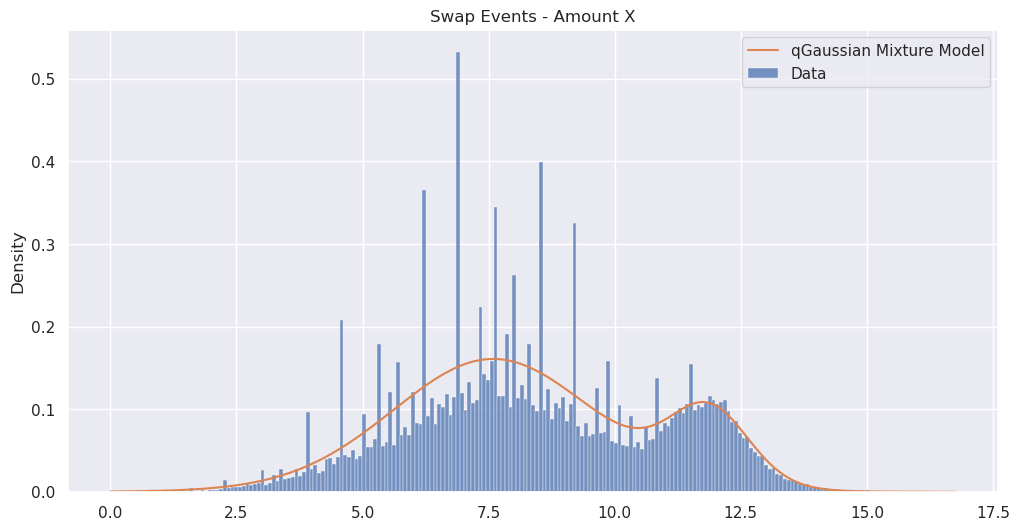

In [13]:
x_test = np.log(df_swap_x2y.amount0).values
x_test = x_test[x_test>0]

q = 1
q_gmm = qGMM(n_components=opt_res[1], q=opt_res[0], max_iter=5_000, tol=1e-6)
q_gmm.fit(x_test, init_means=[7.5, 12.5], init_vars=[1.5, 1])
print(q_gmm.log_likelihood)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x_test, ax=ax, stat='density', label='Data')
pdf = q_gmm.pdf( np.linspace(np.min(x_test), np.max(x_test), 10000) )
sns.lineplot(x=np.linspace(np.min(x_test), np.max(x_test), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='qGaussian Mixture Model')
plt.title("Swap Events - Amount X")
ax.legend()
plt.show()

In [14]:
# Comparison test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}

In [17]:
q_gmm_base = qGMM(n_components=opt_res[1], q=1, max_iter=5_000, tol=1e-6)
q_gmm_base.fit(x_test, init_means=[7.5, 12.5], init_vars=[1.5, 1])

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

test_res = boot_test(x_test, q_gmm.pdf, q_gmm_base.pdf, random_seed)
test_res

{'statistic': -14.89930158712325, 'p_value': 0.0}

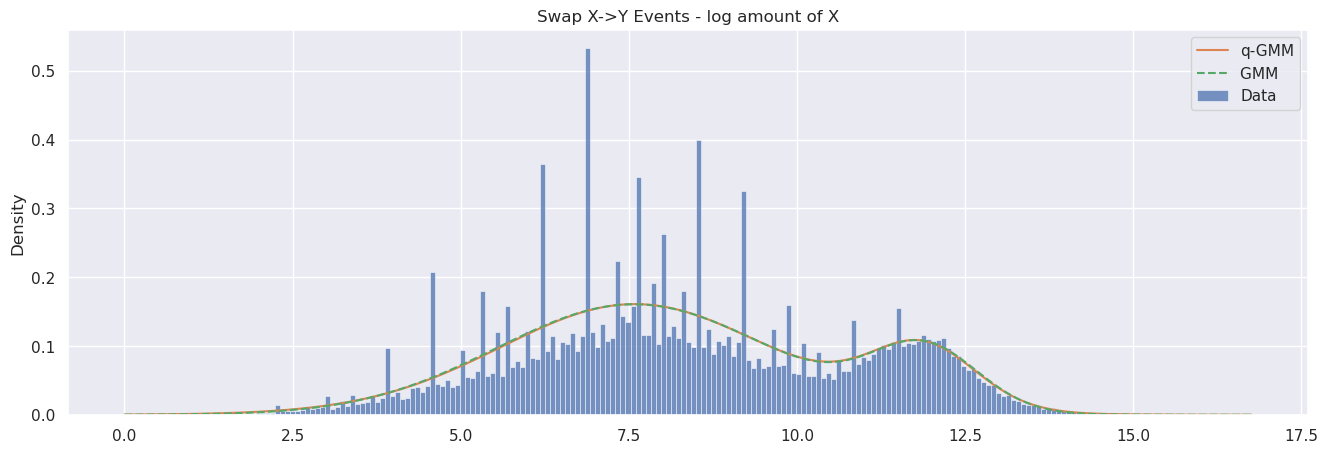

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
sns.histplot(x_test, ax=ax, stat='density', label='Data')
pdf = q_gmm.pdf( np.linspace(np.min(x_test), np.max(x_test), 10000) )
sns.lineplot(x=np.linspace(np.min(x_test), np.max(x_test), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='q-GMM')
pdf_base = q_gmm_base.pdf( np.linspace(np.min(x_test), np.max(x_test), 10000) )
sns.lineplot(x=np.linspace(np.min(x_test), np.max(x_test), 10000),
             y=pdf_base, linestyle='--',
            ax=ax, color=sns.color_palette()[2], label='GMM ')
plt.title("Swap X->Y Events - log amount of X")
ax.legend()
plt.show()

In [22]:
x_test = np.log(-df_swap_y2x.amount0).values
x_test = x_test[x_test>0]

opt_res = optimize_qGMM(x_test, seed=2)
print(opt_res)

qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
(array([1.08379213]), 2,  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2240411.940300607
       x: [ 1.084e+00]
     nit: 7
     jac: [-9.375e-02]
    nfev: 14
    njev: 7)


-2240411.9403003165


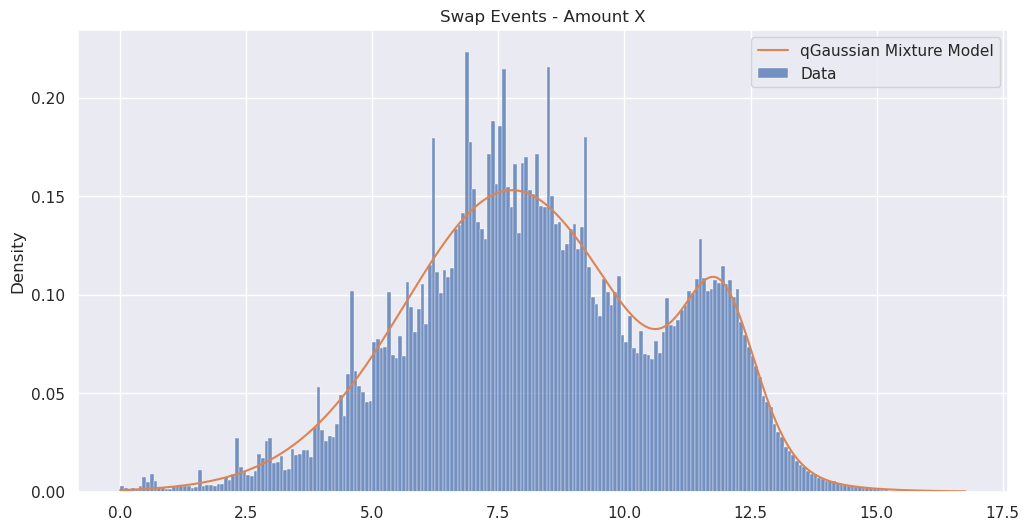

In [23]:
x_test = np.log(-df_swap_y2x.amount0).values
x_test = x_test[x_test>0]

q = 1
q_gmm = qGMM(n_components=opt_res[1], q=opt_res[0], max_iter=5_000, tol=1e-6)
q_gmm.fit(x_test, init_means=[7.5, 12.5], init_vars=[1.5, 1])
print(q_gmm.log_likelihood)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x_test, ax=ax, stat='density', label='Data')
pdf = q_gmm.pdf( np.linspace(np.min(x_test), np.max(x_test), 10000) )
sns.lineplot(x=np.linspace(np.min(x_test), np.max(x_test), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='qGaussian Mixture Model')
plt.title("Swap Events - Amount X")
ax.legend()
plt.show()

In [24]:
q_gmm_base = qGMM(n_components=opt_res[1], q=1, max_iter=5_000, tol=1e-6)
q_gmm_base.fit(x_test, init_means=[7.5, 12.5], init_vars=[1.5, 1])

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

test_res = boot_test(x_test, q_gmm.pdf, q_gmm_base.pdf, random_seed)
test_res

{'statistic': -24.774884758203108, 'p_value': 0.0}

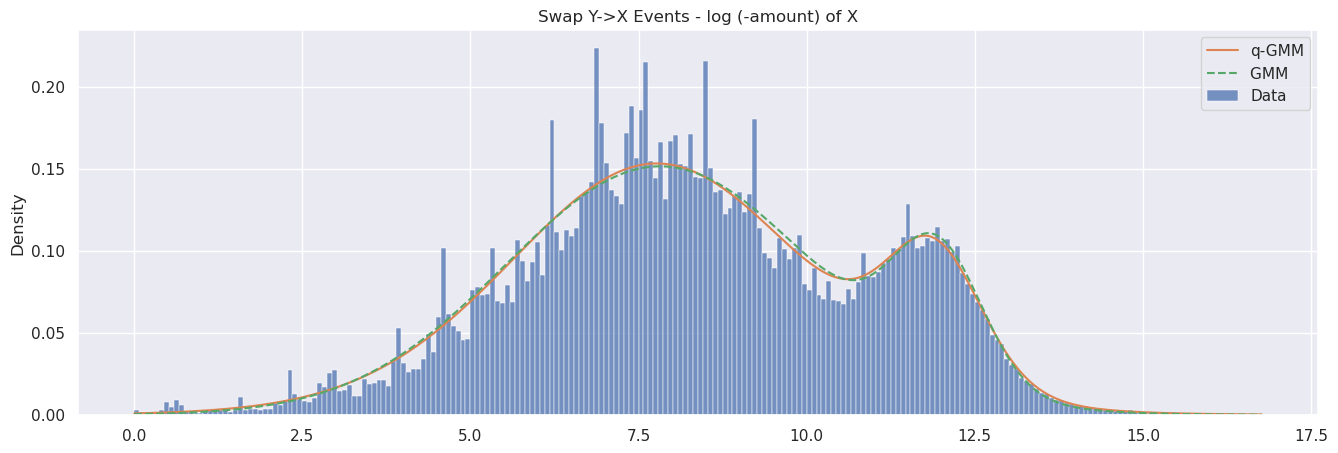

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
sns.histplot(x_test, ax=ax, stat='density', label='Data')
pdf = q_gmm.pdf( np.linspace(np.min(x_test), np.max(x_test), 10000) )
sns.lineplot(x=np.linspace(np.min(x_test), np.max(x_test), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='q-GMM')
pdf_base = q_gmm_base.pdf( np.linspace(np.min(x_test), np.max(x_test), 10000) )
sns.lineplot(x=np.linspace(np.min(x_test), np.max(x_test), 10000),
             y=pdf_base, linestyle='--',
            ax=ax, color=sns.color_palette()[2], label='GMM ')
plt.title("Swap Y->X Events - log (-amount) of X")
ax.legend()
plt.show()